In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sc_special
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
def cuckoo_search(n, m, fit_func, lower_boundary, upper_boundary, iter_num=100, pa=0.25, beta=1.5, step_size=0.1):
    nests = generate_nests(n, m, lower_boundary, upper_boundary)
    fitness = calc_fitness(fit_func, nests)

    best_nest_index = np.argmax(fitness)
    best_fitness = fitness[best_nest_index]
    best_nest = nests[best_nest_index].copy()

    for _ in range(iter_num):
        nests = update_nests(fit_func, lower_boundary, upper_boundary, nests, best_nest, fitness, step_size)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        fitness = calc_fitness(fit_func, nests)
        
        max_nest_index = np.argmax(fitness)
        max_fitness = fitness[max_nest_index]
        max_nest = nests[max_nest_index]

        if (max_fitness > best_fitness):
            best_nest = max_nest.copy()
            best_fitness = max_fitness

    return best_nest, best_fitness

In [3]:
def generate_nests(n, m, lower_boundary, upper_boundary):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    nests = np.empty((n, m))

    for each_nest in range(n):
        nests[each_nest] = lower_boundary + np.random.rand(m) * (upper_boundary - lower_boundary)

    return nests

In [4]:
def update_nests(fit_func, lower_boundary, upper_boundary, nests, best_nest, fitness, step_coefficient):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        step_size = step_coefficient * steps[each_nest] * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m)
        new_nests[each_nest] += step_size * step_direction
        # Updated section: limiting new nest locations with np.clip
        new_nests[each_nest] = np.clip(new_nests[each_nest], lower_boundary, upper_boundary)

    new_fitness = calc_fitness(fit_func, new_nests)
    nests[new_fitness > fitness] = new_nests[new_fitness > fitness]
    
    return nests

In [5]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):
        if np.random.rand() < pa:
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # Updated section: limiting new nest locations with np.clip
            nests[each_nest] = np.clip(nests[each_nest], lower_boundary, upper_boundary)
    
    return nests

In [6]:
def levy_flight(n, m, beta):
    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [7]:
def calc_fitness(fit_func, nests):
    n, m = nests.shape
    fitness = np.empty(n)

    for each_nest in range(n):
        fitness[each_nest] = fit_func(nests[each_nest])

    return fitness

In [62]:
def fit_func(nest):
    A, l_pos, epsilon_f_pos, l_neg, epsilon_f_neg = nest
    df_ex = pd.read_csv('data/data_ocv_ex.csv')
    df_sim = pd.read_csv('data/data_ocv_sim_ex.csv')

    v_t = df_ex['Voltage[V]']
    v_hat_t = df_sim['Voltage[V]']
    
    FF_V = mean_squared_error(v_t, v_hat_t)

    F = 96485.33212
    theta_0_pos = 0.915
    theta_0_neg = 0.008
    theta_100_pos = 0.254
    theta_100_neg = 0.855
    c_s_pos_max = 63104.0
    c_s_neg_max = 33133.0
    FF_C = np.abs((A * l_pos * epsilon_f_pos * F * c_s_pos_max * (theta_0_pos - theta_100_pos) / 3600) - 
                  (A * l_neg * epsilon_f_neg * F * c_s_neg_max * (theta_100_neg - theta_0_neg) / 3600))
    
    # Update section: normalise FF_V and FF_C and check that the denominator is zero
    if np.max(v_t) != np.min(v_t):
        FF_V_norm = (FF_V - np.min(v_t)) / (np.max(v_t) - np.min(v_t))
    else:
        FF_V_norm = 0

    if np.max(FF_C) != np.min(FF_C):
        FF_C_norm = (FF_C - np.min(FF_C)) / (np.max(FF_C) - np.min(FF_C))
    else:
        FF_C_norm = 0
    
    w_Vn = 0.02
    w_c = 1 - w_Vn
    FF_M = w_Vn * FF_V_norm + w_c * FF_C_norm
    
    return FF_M

In [63]:
if __name__ == '__main__':
    lower_bounds = [0.378, 35, 0.35, 35, 0.4]
    upper_bounds = [0.395, 79, 0.5, 79, 0.5,]

    best_nest, best_fitness = cuckoo_search(50, 5, fit_func, lower_bounds, upper_bounds, step_size=0.4)

    print('Max fitness: %.5f, Best nest position: (A: %.5f, l_pos: %.5f, epsilon_f_pos: %.5f,l_neg: %.5f, epsilon_f_neg: %.5f)' 
          % (best_fitness, best_nest[0], best_nest[1], best_nest[2], best_nest[3], best_nest[4]))

Max fitness: -0.02941, Best nest position: (A: 0.39136, l_pos: 62.58015, epsilon_f_pos: 0.48177,l_neg: 52.84706, epsilon_f_neg: 0.47262)


In [38]:
def fit_func(nest):
    A, l_pos, epsilon_f_pos, c_s_pos_max, l_neg, epsilon_f_neg, c_s_neg_max = nest
    df_ex = pd.read_csv('data/data_ocv_ex.csv')
    df_sim = pd.read_csv('data/data_ocv_sim_ex.csv')

    v_t = df_ex['Voltage[V]']
    v_hat_t = df_sim['Voltage[V]']
    
    FF_V = mean_squared_error(v_t, v_hat_t)

    F = 96485.33212
    theta_0_pos = 0.915
    theta_0_neg = 0.008
    theta_100_pos = 0.254
    theta_100_neg = 0.855
    FF_C = np.abs((A * l_pos * epsilon_f_pos * F * c_s_pos_max * (theta_0_pos - theta_100_pos) / 3600) - 
                  (A * l_neg * epsilon_f_neg * F * c_s_neg_max * (theta_100_neg - theta_0_neg) / 3600))
    
    # Update section: normalise FF_V and FF_C and check that the denominator is zero
    if np.max(v_t) != np.min(v_t):
        FF_V_norm = (FF_V - np.min(v_t)) / (np.max(v_t) - np.min(v_t))
    else:
        FF_V_norm = 0

    if np.max(FF_C) != np.min(FF_C):
        FF_C_norm = (FF_C - np.min(FF_C)) / (np.max(FF_C) - np.min(FF_C))
    else:
        FF_C_norm = 0
    
    w_Vn = 0.8
    w_c = 1 - w_Vn
    FF_M = w_Vn * FF_V_norm + w_c * FF_C_norm
    
    return FF_M

In [39]:
if __name__ == '__main__':
    lower_bounds = [0.378, 35, 0.35, 4.8, 35, 0.4, 2.9]
    upper_bounds = [0.395, 79, 0.5, 5.2, 79, 0.5, 3.3]

    best_nest, best_fitness = cuckoo_search(50, 7, fit_func, lower_bounds, upper_bounds, step_size=0.4)

    print('Max fitness: %.5f, Best nest position: (A: %.5f, l_pos: %.5f, epsilon_f_pos: %.5f, c_s_pos_max: %.5f, l_neg: %.5f, epsilon_f_neg: %.5f, c_s_neg_max: %.5f)' 
          % (best_fitness, best_nest[0], best_nest[1], best_nest[2], best_nest[3], best_nest[4], best_nest[5], best_nest[6]))

Max fitness: -1.17627, Best nest position: (A: 0.39139, l_pos: 46.28898, epsilon_f_pos: 0.36845, c_s_pos_max: 5.14172, l_neg: 62.30658, epsilon_f_neg: 0.43624, c_s_neg_max: 3.26526)


In [64]:
l_pos = best_nest[1] * 1e-6
epsilon_f_pos = best_nest[2]
l_neg = best_nest[3] * 1e-6
epsilon_f_neg = best_nest[4]

In [40]:
# 加载数据
df_ex = pd.read_csv('data/data_ocv_ex.csv')
df_sim = pd.read_csv('data/data_ocv_sim_ex.csv')

v_t = df_ex['Voltage[V]']
v_hat_t = df_sim['Voltage[V]']

# 计算优化前后的MSE
initial_mse = mean_squared_error(v_t, v_hat_t)
print(f'MSE: {initial_mse}')

MSE: 0.0012508164464828703


In [56]:
l_pos_002 = best_nest[1] * 1e-6
epsilon_f_pos_002 = best_nest[2]
l_neg_002 = best_nest[3] * 1e-6
epsilon_f_neg_002 = best_nest[4]

In [57]:
param = pybamm.ParameterValues("OKane2022")
param

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x000002C080D56DE0>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008_arrhenius at 0x000002C080D574C0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008_arrhenius at 0x000002C080D57420>,
 'Electron charge [C]': 1.602176634e-19,
 'Exchange-current density for plating [A.m-2]': <function 

In [43]:
param_1 = pybamm.ParameterValues("OKane2022")
param_1.search("Maximum concentration")

Maximum concentration in negative electrode [mol.m-3]	33133.0
Maximum concentration in positive electrode [mol.m-3]	63104.0


In [65]:
# Create a simple DFN model
model = pybamm.lithium_ion.DFN()
# create experiment
experiment = pybamm.Experiment(
    ["Rest for 901 s",
        (
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
        ) * 10,
     "Discharge at 0.96 A for 134 s"
    ]
    
)
# Setting the current function）
param = pybamm.ParameterValues("OKane2022")
param["Positive electrode thickness [m]"] = l_pos
param["Positive electrode active material volume fraction"] = epsilon_f_pos
param["Negative electrode thickness [m]"] = l_neg
param["Negative electrode active material volume fraction"] = epsilon_f_neg

# Creating Simulation Objects
solver = pybamm.CasadiSolver(mode="safe")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# Running simulations with time ranges consistent with data
solution = simulation.solve(calc_esoh=False)  
# Getting results
time_opt = solution["Time [s]"].entries
# current = solution["Current [A]"].entries
voltage_opt = solution["Terminal voltage [V]"].entries

In [48]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_08 = interp_function(new_time)

In [59]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_02 = interp_function(new_time)

In [66]:
# 插值到每秒一个数据点
# 以下为示例数据
new_time = np.linspace(1, 6115, num=6115)
# 创建插值函数
interp_function = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
# 使用插值函数获取新时间点的电压值
new_voltage_opt_002 = interp_function(new_time)

In [46]:
df_ex_6115 = df_ex.head(6115)
votage_ex = df_ex_6115['Voltage[V]']

In [49]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_08)
print(f'MSE: {mse}')

MSE: 0.002293024576660162


In [61]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_02)
print(f'MSE: {mse}')

MSE: 0.0016812456584033221


In [67]:
# Calculating MSE
mse = mean_squared_error(votage_ex, new_voltage_opt_002)
print(f'MSE: {mse}')

MSE: 0.0010534691294296094


In [50]:
df_sim_6115 = df_sim.head(6115)
voltage_sim = df_sim_6115['Voltage[V]']

In [51]:
# Calculating MSE
mse = mean_squared_error(votage_ex, voltage_sim)
print(f'MSE: {mse}')

MSE: 9.433915857337991e-05


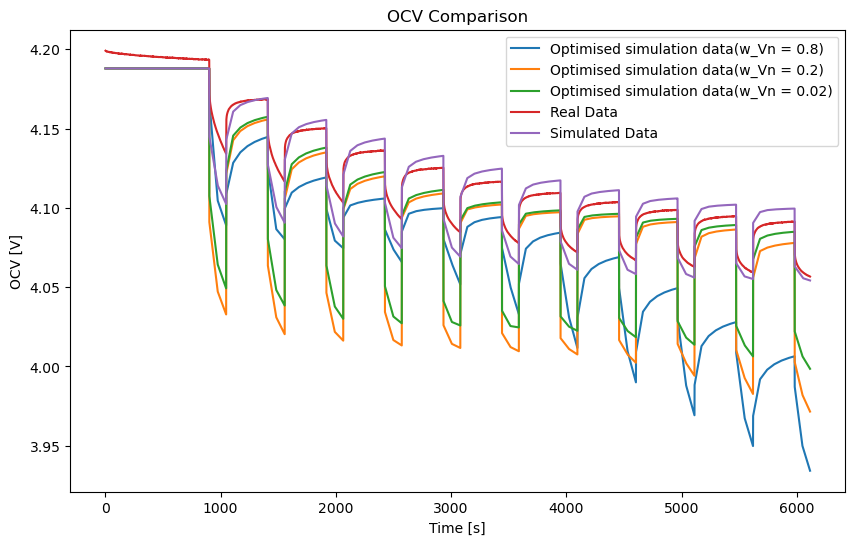

In [69]:
# Plotting comparisons
plt.figure(figsize=(10, 6))
# plt.plot(time_real, voltage_real, label='Real Data')
plt.plot(new_time, new_voltage_opt_08, label='Optimised simulation data(w_Vn = 0.8)')
plt.plot(new_time, new_voltage_opt_02, label='Optimised simulation data(w_Vn = 0.2)')
plt.plot(new_time, new_voltage_opt_002, label='Optimised simulation data(w_Vn = 0.02)')
plt.plot(new_time, votage_ex, label='Real Data')
plt.plot(new_time, voltage_sim, label='Simulated Data')
plt.xlabel('Time [s]')
plt.ylabel('OCV [V]')
plt.title('OCV Comparison')
plt.legend()
plt.show()

In [23]:
# l_pos = best_nest[1] * 1e-6
# epsilon_f_pos = best_nest[2]
# l_neg = best_nest[3] * 1e-6
# epsilon_f_neg = best_nest[4]

In [25]:
# # 创建DFN模型
# model = pybamm.lithium_ion.DFN()

In [26]:
# # 创建实验
# experiment = pybamm.Experiment(
#     ["Rest for 901 s",
#         (
#             "Discharge at 0.96 A for 147 s",
#             "Rest for 361 s",
#         ) * 123,
#      "Discharge at 0.96 A for 134 s"
#     ]
#     
# )

In [27]:
# # 设置模型参数
# param = pybamm.ParameterValues("OKane2022")
# param["Positive electrode thickness [m]"] = l_pos
# param["Positive electrode active material volume fraction"] = epsilon_f_pos
# param["Negative electrode thickness [m]"] = l_neg
# param["Negative electrode active material volume fraction"] = epsilon_f_neg


In [28]:
# # 创建仿真对象
# solver = pybamm.CasadiSolver(mode="fast")
# simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
# # 运行仿真
# solution = simulation.solve()
# 
# # 获取结果
# time_opt = solution["Time [s]"].entries
# voltage_opt = solution["Terminal voltage [V]"].entries

At t = 38.7391 and h = 1.86406e-14, the corrector convergence failed repeatedly or with |h| = hmin.
2024-07-22 18:13:42.308 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


In [32]:
# 插值到每秒一个数据点
# 以下为示例数据
time_opt = np.linspace(0, 63519, 526)  # 模拟时间
time_new = np.arange(1, 63520, 1)
interp_func = interp1d(time_opt, voltage_opt, kind='linear', fill_value="extrapolate")
voltage_new = interp_func(time_new)

In [34]:
# # Load Measurement Data
# real_data = pd.read_csv('data/data_ocv_ex.csv')
# # new_time = np.arange(0, len(real_data['Testtime [s]']))
# # new_time = real_data['Testtime [s]']-min(real_data['Testtime [s]'])
# time_real = time_new
# voltage_real = real_data['Voltage[V]'].values

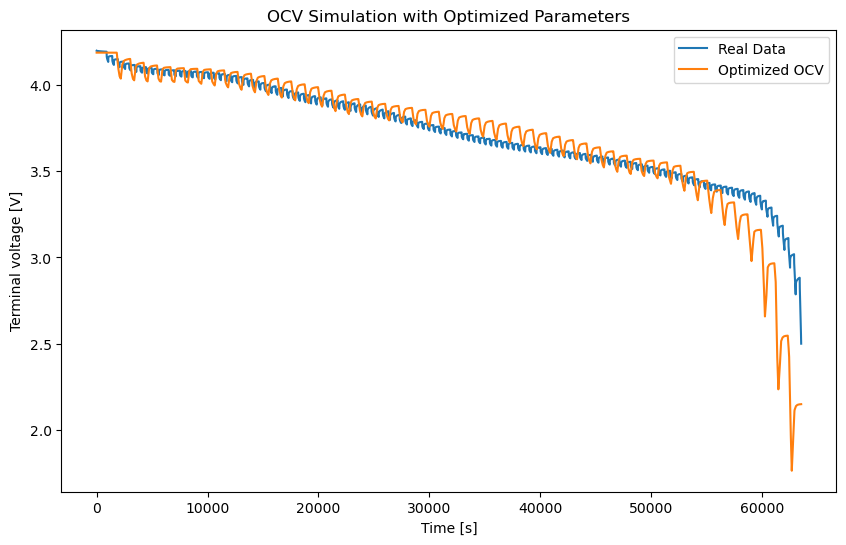

In [35]:
# # 绘制结果
# plt.figure(figsize=(10, 6))
# plt.plot(time_real, voltage_real, label='Real Data')
# plt.plot(time_new, voltage_new, label="Optimized OCV")
# plt.xlabel("Time [s]")
# plt.ylabel("Terminal voltage [V]")
# plt.title("OCV Simulation with Optimized Parameters")
# plt.legend()
# plt.show()

In [36]:
# Calculating MSE
mse = mean_squared_error(voltage_real, voltage_new)
print(f'MSE: {mse}')

MSE: 0.0283874030766705
